# Use supervised learning to learn what articles we want from arxiv and biorxiv

Start by importing arxiv, bioarxiv, and labelled data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from nltk.corpus import stopwords

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#import data, swoger training set and scraped articles
swoger_lib = pd.read_pickle('swoger_lib_withbody.pkl')
df_arxiv = pd.read_pickle('arxiv_withbody.pkl')
df_biorxiv = pd.read_pickle('biorxiv_withbody.pkl')

#remove empty body articles
swoger_lib = swoger_lib[swoger_lib.body!='']
swoger_lib = swoger_lib.dropna(subset=['body'])
df_arxiv=df_arxiv[df_arxiv.body!='']
df_arxiv = df_arxiv.dropna(subset=['body'])
df_biorxiv=df_biorxiv[df_biorxiv.body!='']
df_biorxiv = df_biorxiv.dropna(subset=['body'])

In [3]:
# Make dataframe of all scraped data
df_scraped = pd.concat([df_arxiv,df_biorxiv])
df_scraped.reset_index(inplace=True, drop=True)

# Label data whether it is random from the internet or relevant, from swoger library
df_scraped['status'] = 'random'
swoger_lib['status'] =  'relevant'

# Combine into labelled df
df = pd.concat([df_scraped,swoger_lib])
df.reset_index(inplace=True, drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [4]:
# Cleaning - get rid of false identifiers, like arxiv wording and dates
stop_list = ['bioRxiv', 'arxiv', 'granted', 'doi','license', 'perpetuity',
            'preprint', 'peer', 'display', 'posted', 'copyright', 'holder',
            'funder', 'reviewed', 'dx', 'biorxiv', 'online', 'cid', 'org',
            'author', 'available', 'http', 'vol', 'reserved', 'reuse', 'permission',
            'international', 'rights', 'cc', 'nc']
big_regex = re.compile('|'.join(map(re.escape, stop_list)))
df.body = df.body.str.lower().apply(lambda x: big_regex.sub("", x))

from string import digits
remove_digits = str.maketrans('', '', digits)
df.body = df.body.str.lower().apply(lambda x: x.translate(remove_digits))

# Create pipeline of TF-IDF, allow for addition of new ideas

List of additional parameters:
    - none


In [5]:
#classes to make sure pipeline grabs values correctly
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [6]:
#NOT USED, YET
# Pipeline of tf-idf to be sent to classification

# Preprocessor for tf-idf to remove numbers
def no_number_preprocessor(tokens):
    # This replaces it with 'NUM'
    #r = re.sub('(\d)+', 'NUM', tokens.lower())
    # This alternative just removes numbers:
    r = re.sub('(\d)+', '', tokens.lower())
    return r

text = Pipeline([
                ('selector', TextSelector(key='body')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=300, 
                                          stop_words='english', preprocessor=no_number_preprocessor))
            ])



feats = FeatureUnion([
                      ('body', text)
                     ])

In [7]:
# Split into train and test datasets
train_data, test_data = train_test_split(df, stratify=df.status, test_size=0.2, random_state=42)

#NOT USED, YET
X_test = feats.fit_transform(test_data)
X_train = feats.transform(train_data)

#y_test = test_data.status.astype(float)
#y_train = train_data.status.astype(float)

y_test = test_data.status
y_train = train_data.status

In [8]:
# Build the classification pipeline
text_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=400, stop_words='english')),
                     ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])


# Train the classifier
text_clf.fit(map(str, train_data.body.values), y_train)

# Predict on test data
predicted = text_clf.predict(map(str, test_data.body.values))

In [9]:
# Classification report: precision, recall and f1-score per class
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

     random       0.99      0.95      0.97       107
   relevant       0.96      0.99      0.98       134

avg / total       0.98      0.98      0.98       241



In [10]:
# Get tf-idf vectorizer and random forest classifier from pipeline
tfidf = text_clf.steps[0][1]
rf = text_clf.steps[1][1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(rf.feature_importances_)


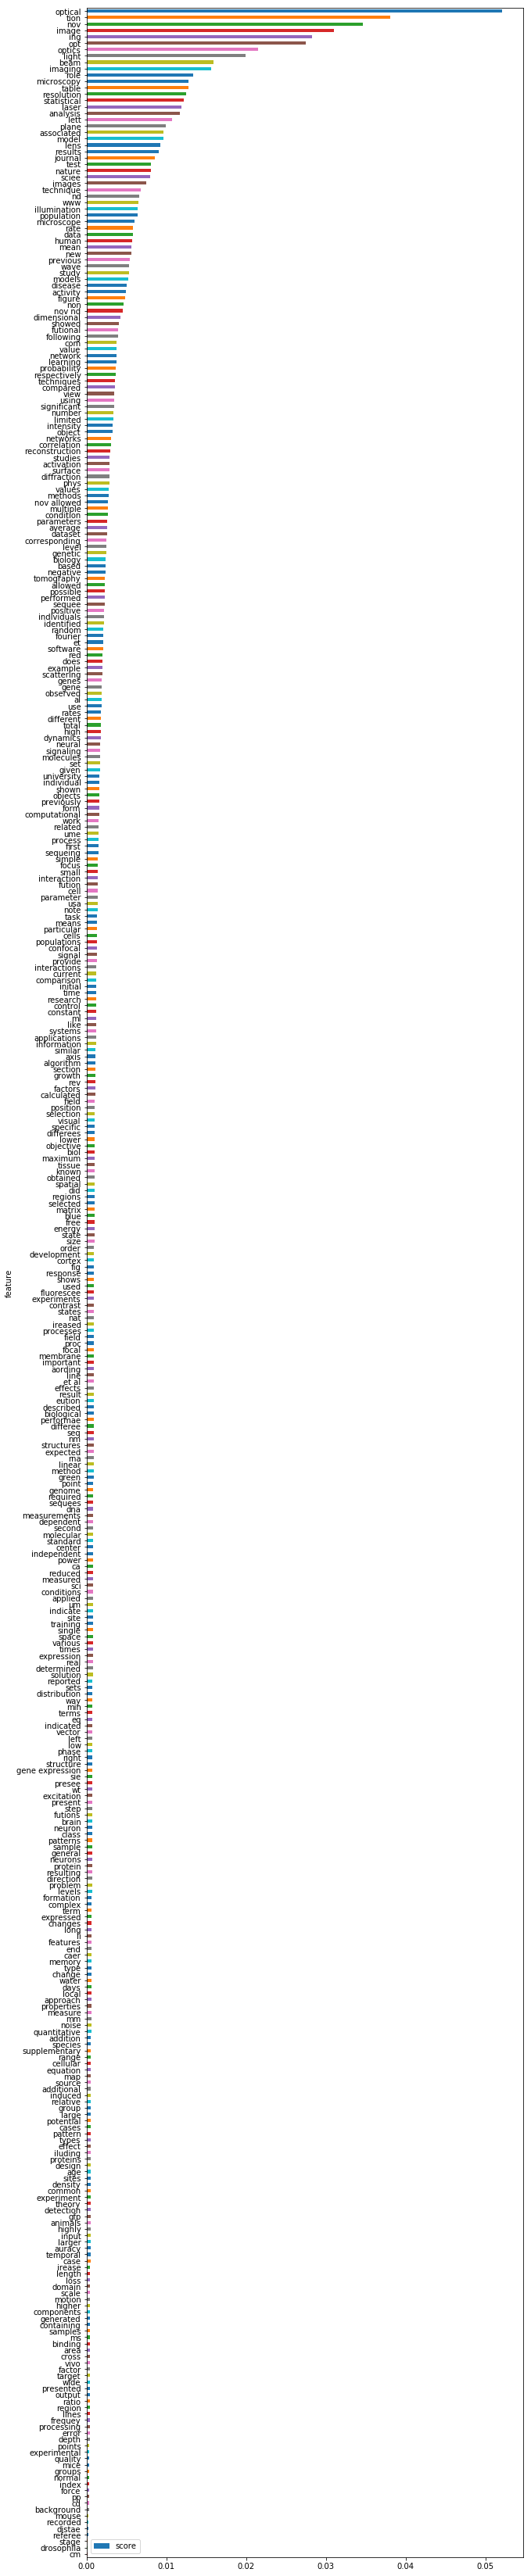

In [11]:
# Plot the feature importances of the random forest
tfidf_array = pd.DataFrame({'feature':tfidf.get_feature_names(), 'score':rf.feature_importances_})
sorted_tfidf_array = tfidf_array.sort_values('score', ascending=False)

plot = sorted_tfidf_array.plot.barh(x = 'feature', y='score', figsize=(10,60))
plt.gca().invert_yaxis()

In [12]:
fig = plot.get_figure()
fig.savefig('tf_idf_weights.pdf')

# Now let's see what this finds from new data

Latest arxiv and biorxiv articles.

In [13]:
# Import and drop empty values in 'body', combine into one dataframe
df_arxiv_today = pd.read_pickle('arxiv_withbody2019-03-22.pkl')
df_biorxiv_today = pd.read_pickle('biorxiv_withbody2019-03-22.pkl')

df_arxiv_today=df_arxiv_today[df_arxiv_today.body!='']
df_arxiv_today = df_arxiv_today.dropna(subset=['body'])
df_biorxiv_today=df_biorxiv_today[df_biorxiv_today.body!='']
df_biorxiv_today = df_biorxiv_today.dropna(subset=['body'])

df_today = pd.concat([df_arxiv_today,df_biorxiv_today])
df_today.reset_index(inplace=True, drop=True)

FileNotFoundError: [Errno 2] No such file or directory: 'arxiv_withbody2019-03-22.pkl'

In [14]:
df_biorxiv_today.shape

(1000, 6)

In [15]:
# Clean again - get rid of false identifiers, like arxiv wording and dates
stop_list = ['bioRxiv', 'arxiv', 'granted', 'doi','license', 'perpetuity',
            'preprint', 'peer', 'display', 'posted', 'copyright', 'holder',
            'funder', 'reviewed', 'dx', 'biorxiv', 'online', 'cid', 'org',
            'author', 'available', 'http', 'vol', 'reserved', 'reuse', 'permission',
            'international', 'rights', 'cc', 'nc']
big_regex = re.compile('|'.join(map(re.escape, stop_list)))
df_today.body = df_today.body.str.lower().apply(lambda x: big_regex.sub("", x))

remove_digits = str.maketrans('', '', digits)
df_today.body = df_today.body.str.lower().apply(lambda x: x.translate(remove_digits))

In [16]:
# Run classifier on 
X_today = df_today
pred_today = text_clf.predict(map(str, X_today.body.values))

In [17]:
df_today['predicted_status']=pred_today

In [18]:
df_relevant = df_today[df_today['predicted_status']=='relevant']
df_relevant.reset_index(inplace=True, drop=True)

In [19]:
import math
for ix in range(len(df_relevant)):
    if isinstance(df_relevant.id.loc[ix], str):
        print("https://arxiv.org/pdf/%s.pdf" %df_relevant['id'].loc[ix])
    else:
        print(df_relevant.atom_path.loc[ix].replace('/biorxiv/', 'https://www.biorxiv.org/content/biorxiv/').replace( '.atom','')+'.full.pdf')
        

https://arxiv.org/pdf/1803.11516.pdf
https://arxiv.org/pdf/1804.01342.pdf
https://arxiv.org/pdf/1806.06016.pdf
https://arxiv.org/pdf/1808.05149.pdf
https://arxiv.org/pdf/1809.03438.pdf
https://arxiv.org/pdf/1809.08430.pdf
https://arxiv.org/pdf/1810.05835.pdf
https://arxiv.org/pdf/1810.09259.pdf
https://arxiv.org/pdf/1902.02905.pdf
https://arxiv.org/pdf/1902.05568.pdf
https://arxiv.org/pdf/1902.05621.pdf
https://arxiv.org/pdf/1902.05859.pdf
https://arxiv.org/pdf/1902.05883.pdf
https://arxiv.org/pdf/1902.06130.pdf
https://arxiv.org/pdf/1902.06390.pdf
https://arxiv.org/pdf/1902.07310.pdf
https://arxiv.org/pdf/1902.08470.pdf
https://arxiv.org/pdf/1902.08578.pdf
https://arxiv.org/pdf/1902.08871.pdf
https://arxiv.org/pdf/1902.09638.pdf
https://arxiv.org/pdf/1902.10234.pdf
https://www.biorxiv.org/content/biorxiv/early/2019/03/03/559559.full.pdf
https://www.biorxiv.org/content/biorxiv/early/2019/03/03/505404.full.pdf
https://www.biorxiv.org/content/biorxiv/early/2019/03/03/566315.full.pdf
http